<a href="https://colab.research.google.com/github/kpjaskie/SenSIP-IRES2020/blob/master/Machine_Learning_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Algorithms

In this notebook, we will be performing different classification algorithms for comparison on simulated and real-world datasets.

In statistics and machine learning, classification is the problem of identifying to which of a set of categories or classes a new observation belongs.  This is done by creating a model from data whose class membership is known.  When the data belongs to one of two classes, this is refered to as **binary classification**.  When there are more than two classes represented,, this is called **multi-class classification**.

Examples of **binary classification** include determining whether an email is "spam" or "non-spam" or determining if a patient "is pregnant" or "is not pregnant".

Examples of **multi-class classification** include determening what is causing a patients illness (out of many possible diseases) based on observed characteristics of the patien (sex, blood pressure, presence or absence of certain symptoms, etc.) or identifying an animal, plant, or make and model of vehicle in a photograph.

![picture](https://miro.medium.com/max/972/1*SwXHlCzh-d9UqHOglp3vcA.png)

In this tutorial, we will mostly focus on binary classification using simulated datasets.  However, we will introduce some real-world examples towards the end.


In [61]:
# First, we need to import the relavent libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# To create simulated data
from sklearn.datasets import make_blobs

# To create confusion matrices and metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import seaborn as sns; sns.set()  # for plotting confusion matrices
from tabulate import tabulate


# Generate Data

Let's make some simulated data to work with.  As mentioned above, we will start with only two classes so that we can perform binary classification.  In binary classification, we often name the classes "positive" and "negative".  If one of the classes is smaller than the other, it is typically called the positive class.

In this example, the classes are the same size but the degree of separability (how well separated the classes are from one another) is based on the standard deviation for each cluster.  Try different standard deviations below to see how it affects the data.  A good value for this dataset is around 0.75.

*Note: The slide-bar is a type of google form.  If you want to see the code behind this data generation, double-click anywhere near the slide-bar.*

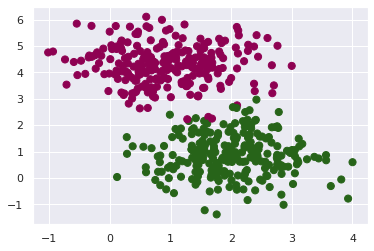

In [63]:
#@title Generate binary data

Standard_Deviation = 0.75 #@param {type:"slider", min:0, max:2, step:0.01}

#Let's make simple data to classify.
X, y = make_blobs(n_samples=500, 
                  centers=2, 
                  random_state=0, 
                  cluster_std=Standard_Deviation)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='PiYG');

From this, we can clearly see the two well defined classes of data - red and green.



## Break into train/validation/test sets
Before we can train a model on this data, we want to **RANDOMLY** break the data into training, validation, and test sets.  By breaking it apart in this manner, we will be able to effectively predict how accurate our model is.

Our process will be as follows:
1. Train the data on the training set.
2. Test the data on the validation set.
3. Adjust any available hyperparameters.
4. Repeat steps 1-3 until you select the best hyperparameters for the data.
5. Train the data on the combined training and validation sets using the selected hyperparameters from step 4.
6. Perform the final test on the reserved test set.

Notice that since the built in sklearn function "train_test_split" only breaks the sets into two parts, we have to use the function twice to get three sets.
* Once to separate the initial training data.
* Again to separate the validation and test sets from the remaining data.

In [52]:
from sklearn.model_selection import train_test_split

#Here, our training set is composed of 70% of the data and our validation
#and test sets are each composed of 15% of the data
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_remaining, y_remaining, test_size=0.5)

print("Training Size   = ", X_train.shape[0])
print("Validation Size = ", X_val.shape[0])
print("Test Size       = ",  X_test.shape[0])

Training Size   =  350
Validation Size =  75
Test Size       =  75


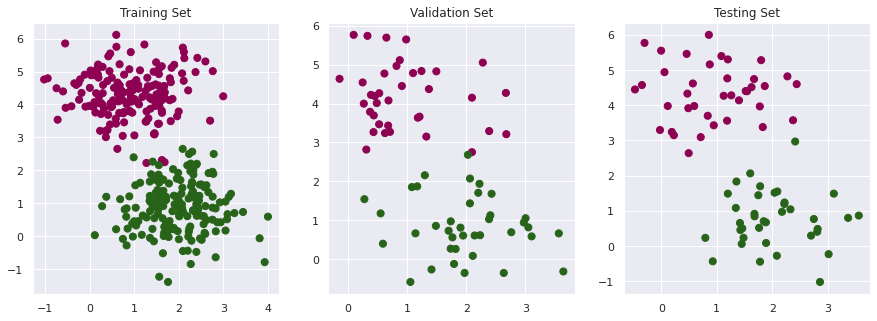

In [53]:
#@title Visualize Sets

from matplotlib import gridspec

fig, ax = plt.subplots(1, 3, 
                       gridspec_kw={
                           'width_ratios': [2, 2, 2],
                           'height_ratios': [1]},
                       figsize=(15,5))

ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='PiYG');
ax[0].set_title('Training Set')

ax[1].scatter(X_val[:, 0], X_val[:, 1], c=y_val, s=50, cmap='PiYG');
ax[1].set_title('Validation Set')

ax[2].scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap='PiYG');
ax[2].set_title('Testing Set')

plt.show()


# Evaluating a Classification Algorithm

Before we begin working with classification algorithms, we need to introduce some of the standard classification evaluation techniques so we will be able to differentiate a good classification model from a bad one.

We will discuss:
* Confusion Matrices
* Metrics including Accuracy, Recall, Precision, and F-score (also called the F1-score).


## Confusion Matrices

Machine Learning practitioners' first tool for evaluating classification models is to generate and inspect the confusion matrix.  A confusion matrix for a binary classification problem has two rows and two columns. The real answers often depicted as the columns and the model predicted answers are given as the rows, but this is not always true - you have to look at the axis labels to be sure.
<br/><br/>

The image below depicts a confusion matrix for a pregnancy test.  A real confusion matrix will have numbers in each cell showing how many data samples your classification model classified into each category: True Positives (TP), False Positives (FP), False Negatives (FN), or True Negatives (TN).

<div>
<img src="http://drive.google.com/uc?export=view&id=1qAFkAshy_JCGORVioC1sMaVZXKVLsJLn" width="600"/>
</div>





Ideally, we'd like to have a confusion matrix where the True Positives and True Negatives were high and the False Positives and False Negatives were low.  When this is true, the diagnonal from top left to bottom right would have large numbers and everywhere else would be low.
<br/><br/>
**IMPORTANT: The orientation of a confusion matrix is NOT standard and some places such as Wikipedia have the postives in the first row and some places like sklearn have the negatives in the first row.  You MUST read the axis to understand the confusion matrix.  In the plot below, and in future python examples, the orientation is:**

\begin{bmatrix}
TN & FP \\
FN & TP 
\end{bmatrix}


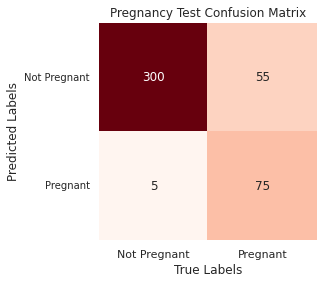

In [64]:
#@title Pregnancy Confusion Matrix Example
#@markdown The following is an example confusion matrix that has been 
#@markdown generated in Python.  Notice that the row and column
#@markdown labels have been swapped from the image above.  **It
#@markdown is important to always pay attention to these labels.**

TP_preg =  75
FP_preg =  5
FN_preg =  55
TN_preg =  300

y_real = np.concatenate((np.ones((TP_preg+FN_preg,)), 
                         np.zeros((TN_preg+FP_preg,))))
y_predicted = np.concatenate((np.ones((TP_preg,)), 
                              np.zeros((FN_preg + TN_preg,)), 
                              np.ones((FP_preg,))))

CM_example = confusion_matrix(y_real, y_predicted)

ax = sns.heatmap(CM_example.T, square=True, annot=True, 
                 fmt='d', cbar=False, cmap="Reds")

ax.set_xticklabels(('Not Pregnant','Pregnant'))
ax.set_yticklabels(('Not Pregnant','Pregnant'), 
    rotation=0, fontsize="10", va="center")

plt.xlabel("True Labels")
plt.ylabel("Predicted Labels");
plt.title("Pregnancy Test Confusion Matrix")
plt.show()

## Evaluation Metrics

While the confusion matrices described above are increadibly useful in evaluating how your model is performing, sometimes it's nice to have a **summary statistic** or a single value to evaluate your model.  These are often called **metrics**.  Here, we're going to go through the most commonly used classification metrics.  These metrics all use the TP, FP, TN, and FN shown in the confusion matrix above.

### Accuracy

A model's accuracy is probably the most commonly used classification metric.  

The accuracy is calculated as:
$$ Accuracy = \frac{TP + TN}{TP + FP + TN + FN} $$

This accuracy can either be calculated manually using this formula, or you can ask sklearn to calculate it for you.  

```
#Manual Calculation
accuracy = (TP + TN)/(TP + FP + TN + FN)
```

```
#Sklearn Calculation
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_real, y_predicted)
```


### Precision and Recall

Two other important metrics that are commonly used are the Precision and the Recall.  

<center>
<div>
<img src="http://drive.google.com/uc?export=view&id=1A-x7MJeGDoQrxKXWfGZXpKoLDahUHHhq" width="700"/>
</div>
</center>

Precision and recall are important in many applications and models can be adjusted to increase one, often at the expense of the other.

* For example, when predicting a deadly disease, doctors might prefer to scare somebody with a false positive instead of missing somebody through a false negative.  In this case, having a high recall is preferred to precision.

* In other cases, such as when a credit card company declines a credit card due to suspected fraud, they're going to make their customers very unhappy if there was no fraud.  In this case, the credit card company would prefer a higher precision over a high recall.

Understanding the differences and tradeoffs between these two metrics, helps a data scientist focus on what's best for the situation.

The Precision and Recall can either be calculated manually or using sklearn.

```
#Manual Calculation
precision = TP/(TP + FP)
recall = TP/(TP + FN)
```

```
#Sklearn Calculation
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
precision = precision_score(y_real, y_predicted)
recall = recall_score(y_real, y_predicted)
```

### F-Score

The F-score (called the F1-score in statistics) is a number between 0 and 1 that equals the harmonic mean between recall and precision.  This means that it is high when both precision and recall are high and low if either one is low.  It is often used as an alternative to accuracy.
<center>
<div>
<img src="http://drive.google.com/uc?export=view&id=1EXsN_2shynQxzJE3Lvj8yWSkX8Kb9SwD" width="300"/>
</div>
</center>

When your class sizes are pretty similar, accuracy is an extremely useful metric.  But when your class sizes are skewed (meaning they have very different sizes), the F-score is a better metric.

Example:
* Your data contains 990 negative samples and only 10 positive samples. Your classifier always predicts that everything is negative, you will have an accuracy of 99%.
* So is this a *useful* classifier?  No!  Despite having 99% accuracy, this classifier is worthless.  This is better captured by the F-score which equals zero in this scenario.

When the class sizes are the same, the accuracy and the F-score will be similar.

The F-Score can either be calculated manually or using sklearn.

```
#Manual Calculation
fscore = 2 * (precision * recall)/(precision + recall)
```

```
#Sklearn Calculation
from sklearn.metrics import f1_score
fscore = f1_score(y_real, y_predicted)
```

## Experimentation

Now that you've learned about the different classification evaluation metrics, let's play with some numbers.  For simplicity, we're going to use disease **X** diagnosis as an example.  We will define those with the disease to be  **positive** and those without to be **negative**.

Remember: 
* TP = Has **X** classified as having **X (correct)**
* FP = Does not have **X** but classified as having **X (incorrect)**
* FN = Has **X** but classified as not having **X (incorrect)**
* TN = Does not have **X** and classified as not having **X (correct)**






Metric     Value
---------  -------
Accuracy   0.94
Precision  0.94
Recall     0.96
F-score    0.95



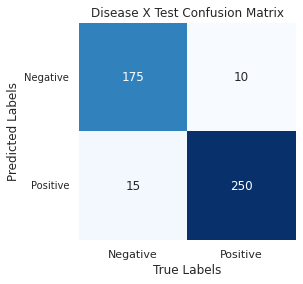

In [7]:
#@title Data

TP =  250#@param {type:"integer"}
FP =  15#@param {type:"integer"}
FN =  10#@param {type:"integer"}
TN =  175#@param {type:"integer"}

y_real = np.concatenate((np.ones((TP+FN,)), np.zeros((TN+FP,))))
y_predicted = np.concatenate((np.ones((TP,)), np.zeros((FN + TN,)), 
                              np.ones((FP,))))

#@title Results
accuracy_ex = round((TP + TN)/(TP + FP + TN + FN), 2)

if TP == 0 and FP == 0:
    precision_ex = 0
else:
    precision_ex = round(TP/(TP + FP), 2)

if TP == 0 and FN == 0:
    recall_ex = 0
else:
    recall_ex = round(TP/(TP + FN), 2)

if precision_ex == 0 and recall_ex == 0:
    fscore_ex = 0
else:
    fscore_ex = round(2 * (precision_ex * recall_ex)/(precision_ex + recall_ex), 2)

print(tabulate([['Accuracy', accuracy_ex], 
                ['Precision', precision_ex],
                ['Recall', recall_ex],
                ['F-score', fscore_ex],
                [' ', ' ']], 
               headers=['Metric', 'Value']))

CM_example = confusion_matrix(y_real, y_predicted)

ax = sns.heatmap(CM_example.T, square=True, annot=True, 
                 fmt='d', cbar=False, cmap="Blues")

ax.set_xticklabels(('Negative', 'Positive'))
ax.set_yticklabels(('Negative', 'Positive'), 
    rotation=0, fontsize="10", va="center")

plt.xlabel("True Labels")
plt.ylabel("Predicted Labels");
plt.title("Disease X Test Confusion Matrix")
plt.show()

### Some Things to Try

In the data fields above, see if you can change the TP, TN, FP, FN so that you get:
1.   The accuracy to equal 75%.
2.   The precision and recall to be less than 1 but equal to one another.
3.   The F-score to be greater than the accuracy.

# Logistic Regression

When classifying data using logistic regression, the classifier will calculate the probability that each datapoint belongs to the positive class.

Logistic regression works by fitting data to a sigmoid function.  The logit sigmoid function has the following equation:

$$Sigmoid(x)=\frac{1}{1+e^{-\theta x}}$$

If we were to plot this, we would get the following curve.

<center>
<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1200px-Logistic-curve.svg.png" width="300"/>
</div>
</center>

You can think of this as taking a linear model of **binary** data and converting it to probabilities between zero and one.  

## Example

Let's see an example of this to understand the intuition behind this techique.

Here's an example of test scores for a difficult test based on the number of hours each student studied.  Noice the students who passed the test are marked in green and the students who failed are marked in red.

<center>
<div>
<img src="http://drive.google.com/uc?export=view&id=1J-yVXGpzgb4tasjngwPpMK1fDyOyPn5i" width="300"/>
</div>
</center>

Now we could just perform a linear regression and try to predict what score a person would get given their hours of study, but while the data is sort of linear in a diagonal from the lower left to the upper right of the graph, it is not a very strong relationship.  

Instead, we're going to create a logistic regression model for the classes - students who passed vs those that did not pass.  To do this, let's just look at the pass/fail information.

<center>
<div>
<img src="http://drive.google.com/uc?export=view&id=1SpgYf4zWsLFOJNYilCpZf5wbV6NgHXXb" width="400"/>
</div>
</center>
<br/><br/>
Now we *could* fit a line to this information...

<center>
<div>
<img src="http://drive.google.com/uc?export=view&id=1RabrQX2cxjyq4XANWt_panMPULNQUEbJ" width="400"/>
</div>
</center>

But notice that not only does this not fit the data well, but we also can't use this to directly calculate the probability of passing the test because this line goes below zero and above one which isn't possible for probabilities. 


The equation for this particular line is:
$$
z = 0.185x - 0.29
$$
<br/><br/>
But if we make this the input to our sigmoid function:

$$
Sigmoid(z)=\frac{1}{1+e^{-(0.185x - 0.29)}}
$$

we'll get the probabilistic output that we're looking for.  This becomes a function for the probability that a student will pass, given the amount of hours they'll study.

<br/><br/>
<center>
<div>
<img src="http://drive.google.com/uc?export=view&id=1UWDMYrOUtaxwiz2Nbv5eN9KRxItYl2Hy" width="400"/>
</div>
</center>

Notice that unlike the straight line above, this sigmoid never goes below zero or above 1, meaning it creates well calibrated probabilities.

<center> * * * </center>


Another way of thinking about this is to imagine increasing the dimensionality of the problem by adding a new axis that contains the probability of a student passing given the number of hours they studied.





<center>
<div>
<img src="http://drive.google.com/uc?export=view&id=1AcFnFx712ck-DxJdChaxcYKl91AjK--_" width="300"/>
</div>
</center>



## Logistic Regression on Simulated Data

So now let's see how we can go about implementing this classifier on the simulated data generated at the top of this notebook.  It is reproduced here as well.

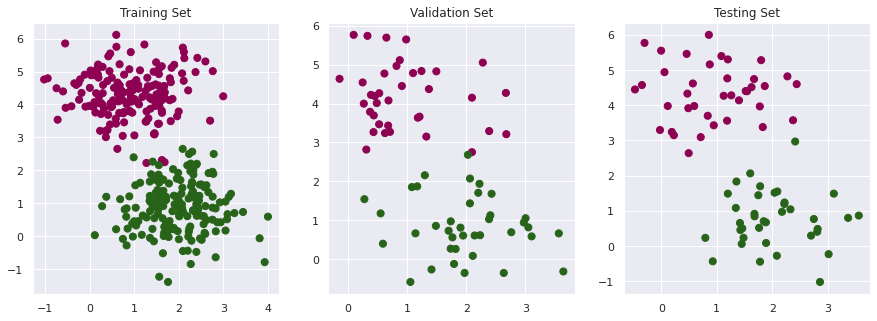

In [54]:
#@title Visualize Sets

from matplotlib import gridspec

fig, ax = plt.subplots(1, 3, 
                       gridspec_kw={
                           'width_ratios': [2, 2, 2],
                           'height_ratios': [1]},
                       figsize=(15,5))

ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='PiYG');
ax[0].set_title('Training Set')

ax[1].scatter(X_val[:, 0], X_val[:, 1], c=y_val, s=50, cmap='PiYG');
ax[1].set_title('Validation Set')

ax[2].scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap='PiYG');
ax[2].set_title('Testing Set')

plt.show()

Now, we're going to learn a model of the test data.


In [56]:
from sklearn.linear_model import LogisticRegression
#from scipy import stats

#First, we need to create a logistic regression model and fit the data to it.
LR_model = LogisticRegression(random_state=0, solver='lbfgs', max_iter=100)
LR_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

That's it!  We've created a model!  Now let's evaluate it using the validation set.  The solid datapoints in the image below are the validation set that we're testing our model on.  The light points are the test data.

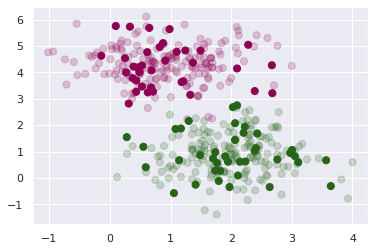

In [60]:
y_hat = LR_model.predict(X_val)

plt.figure(0)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='PiYG', alpha=0.2);
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_hat, s=50, cmap='PiYG');

Now we'll calculate the confusion matrix and summary statistics.

Metric     Value
---------  -------
Accuracy   0.99
Precision  0.97
Recall     1.0
F-score    0.99



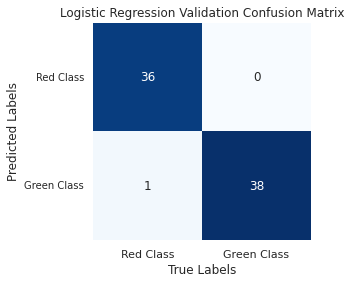

In [67]:
#@title Validation Evaluation

accuracy_logistic = round(accuracy_score(y_val, y_hat), 2)
precision_logistic = round(precision_score(y_val, y_hat), 2)
recall_logistic = round(recall_score(y_val, y_hat), 2)
fscore_logistic = round(f1_score(y_val, y_hat), 2)

print(tabulate([['Accuracy', accuracy_logistic], 
                ['Precision', precision_logistic],
                ['Recall', recall_logistic],
                ['F-score', fscore_logistic],
                [' ', ' ']], 
               headers=['Metric', 'Value']))

CM_logistic = confusion_matrix(y_val, y_hat)

ax = sns.heatmap(CM_logistic.T, square=True, annot=True, 
                 fmt='d', cbar=False, cmap="Blues")

ax.set_xticklabels(('Red Class','Green Class'))
ax.set_yticklabels(('Red Class','Green Class'), 
    rotation=0, fontsize="10", va="center")

plt.xlabel("True Labels")
plt.ylabel("Predicted Labels");
plt.title("Logistic Regression Validation Confusion Matrix")
plt.show()

Now it's our chance to go back and modify the model hyperparameters until we get the best validation accuracy we can get.  

The hyperparameters for this logistic regression model are the solver and maximum number of itterations.
* solver choices: ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, and ‘saga’
* max_itr: The maximum number of itterations before the model stops learning.

In more complex problems, some of the other possible logistic regression parameters (such as the regularization parameter C).  Please see the documentation for more information.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

### Final Logistic Regression Test Evaluation

Once you've tuned the hyperparameters in the model above to get the best possible results on the validation set (this probably won't be much work for this dataset), it's time to combine the original training and validation sets and create a new, final model.  We will then test this final model on our test set to estimate our model's effectiveness.

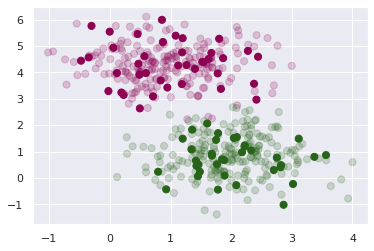

Metric     Value
---------  -------
Accuracy   0.99
Precision  1.0
Recall     0.97
F-score    0.99



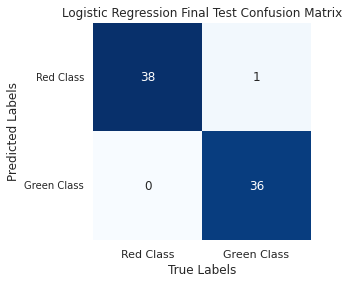

In [70]:
X_final_train = np.concatenate((X_train, X_val), axis=0)
y_final_train = np.concatenate((y_train, y_val), axis=0)

LR_model_final = LogisticRegression(random_state=0, solver='lbfgs', max_iter=100)
LR_model_final.fit(X_final_train, y_final_train)

y_hat_final_test = LR_model_final.predict(X_test)

plt.figure(0)
plt.scatter(X_final_train[:, 0], X_final_train[:, 1], c=y_final_train, s=50, cmap='PiYG', alpha=0.2);
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_hat_final_test, s=50, cmap='PiYG');
plt.show()

accuracy_logistic_final = round(accuracy_score(y_test, y_hat_final_test), 2)
precision_logistic_final = round(precision_score(y_test, y_hat_final_test), 2)
recall_logistic_final = round(recall_score(y_test, y_hat_final_test), 2)
fscore_logistic_final = round(f1_score(y_test, y_hat_final_test), 2)

print(tabulate([['Accuracy', accuracy_logistic_final], 
                ['Precision', precision_logistic_final],
                ['Recall', recall_logistic_final],
                ['F-score', fscore_logistic_final],
                [' ', ' ']], 
               headers=['Metric', 'Value']))

CM_logistic = confusion_matrix(y_test, y_hat_final_test)

ax = sns.heatmap(CM_logistic.T, square=True, annot=True, 
                 fmt='d', cbar=False, cmap="Blues")

ax.set_xticklabels(('Red Class','Green Class'))
ax.set_yticklabels(('Red Class','Green Class'), 
    rotation=0, fontsize="10", va="center")

plt.xlabel("True Labels")
plt.ylabel("Predicted Labels");
plt.title("Logistic Regression Final Test Confusion Matrix")
plt.show()

#Support Vector Machines

A Support Vector Machine 

In [ ]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='PiYG')
#plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

#Neural Network Classifiers